In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

In [20]:
# Install required libraries
!pip install pyunpack
!pip install patool

from pyunpack import Archive
from google.colab import drive
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import numpy as np

In [3]:


# path to the .rar file in your Google Drive
rar_file_path = '/content/drive/MyDrive/New folder (2)/train.rar'

# destination folder in Colab storage to unzip the contents
destination_folder = '/content/unzipped_train_data/'
!mkdir -p "$destination_folder"

# Extracting the contents of the .rar file to the destination folder
Archive(rar_file_path).extractall(destination_folder)



#Data Preprocessing

As the annotations are in xml format so functions are generated to read xml files and extract annotations accordingly.

In pre processing, image values were normalzied and annoattion values were also normalized in range of 0 to 1.

In [4]:


# Function to read annotations

def read_annotations(xml_file, folder_path):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(folder_path, filename)
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    depth = int(root.find('size/depth').text)
    image = cv2.imread(image_path)

    annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymin = int(obj.find('bndbox/ymin').text)
        ymax = int(obj.find('bndbox/ymax').text)

        annotations.append({
            'name': name,
            'bbox': (xmin, ymin, xmax, ymax)
        })

    return {
        'filename': filename,
        'image_path': image_path,
        'width': width,
        'height': height,
        'depth': depth,
        'image': image,
        'annotations': annotations
    }

# Function to preprocess images and annotations for training

def preprocess_data(image, annotations, width,height,input_shape=(224, 224)):
    # Resize the image
    image = cv2.resize(image, input_shape)

    # Normalize pixel values to be in the range [0, 1]
    image = image / 255.0

    # Resize and normalize bounding box coordinates
    processed_annotations = []
    for annotation in annotations:
        bbox = annotation['bbox']
        xmin, ymin, xmax, ymax = bbox

        # Scale bounding box coordinates based on resizing factor
        x_scale = input_shape[1] / (width*224)
        y_scale = input_shape[0] / (height*224)

        processed_bbox = (
            float(xmin * x_scale),
            float(ymin * y_scale),
            float(xmax * x_scale),
            float(ymax * y_scale)
        )

        processed_annotations.append({
            'name': annotation['name'],
            'bbox': processed_bbox
        })
    # print(processed_bbox)
    return image, processed_annotations

# Load and preprocess the dataset

def load_dataset(folder_path, max_images):
    dataset = []
    image_count = 0

    for filename in os.listdir(folder_path):
        if filename.endswith('.xml'):
            xml_file_path = os.path.join(folder_path, filename)
            data = read_annotations(xml_file_path, folder_path)

            # Preprocess the image and annotations
            processed_image, processed_annotations = preprocess_data(data['image'], data['annotations'],data['width'],data['height'])

            dataset.append({
                'image': processed_image,
                'annotations': processed_annotations
            })

            image_count += 1
            if image_count >= max_images:
                break

    return dataset



#Loading Training Data

In [5]:
# Specify the folder containing the images and XML files
folder_path = '/content/unzipped_train_data/train'

# Load and preprocess the dataset
dataset = load_dataset(folder_path, max_images=2200)
unique_categories = set()
for example in dataset:
    for annotation in example['annotations']:
        unique_categories.add(annotation['name'])

# Add a new class for "no object"
unique_categories.add('no_object')

unique_category_to_index = {category: idx for idx, category in enumerate(unique_categories)}

# Create TensorFlow Dataset with multiple bounding boxes per image
data = np.array([example['image'] for example in dataset])

# Assuming you have already initialized targets like this:
num_images = len(dataset)
num_annotations_per_image = 5
num_categories = len(unique_categories)

targets = {
    'labels': np.zeros((num_images, num_annotations_per_image, num_categories), dtype=np.float64),
    'boxes': np.zeros((num_images, num_annotations_per_image, 4), dtype=np.float64)
}

for i, example in enumerate(dataset):
    image_id = np.array([i])
    for j, anno in enumerate(example['annotations']):
        # print(j)
        if j < num_annotations_per_image:
            # Extract bounding box coordinates
            xmin, ymin, xmax, ymax = anno['bbox']
            category_label = unique_category_to_index[anno['name']]

            # Store bounding box coordinates and category label in targets
            targets['boxes'][i, j, :] = [xmin, ymin, xmax, ymax]

            # Convert category label to one-hot encoding
            one_hot_encoding = np.zeros(num_categories, dtype=np.float64)
            one_hot_encoding[category_label] = 1.0
            targets['labels'][i, j, :] = one_hot_encoding

    # Add "no object" class for remaining slots
    for j in range(len(example['annotations']), num_annotations_per_image):
        targets['labels'][i, j, unique_category_to_index['no_object']] = 1.0

# Create TensorFlow Dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    ({'mobilenetv2_1.00_224_input': data},
     {'classification': targets['labels'], 'reshape_bbox': targets['boxes']}))


Two issues were faced while loading dataset, one was drive crashes if we have files in thousands in 1st level folder, it had solution to divide dataset in different level of folders but it was very time consuming.
2nd issue was related to ram. As the image dimensions were very large, so after loading only 2200 images, ram of 12 GB always crashed, we tried many options like loading in batches but didn't work out.

In [6]:
print(len(train_ds))

2200


#Loading Validation Data

In [7]:



# Specify the path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/New folder (2)/valid.zip'  # Replace with your actual zip file path

# Specify the destination folder in Colab runtime storage
extracted_folder_path = '/content/validation_extracted_folder'

# Create the destination folder if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# List the extracted files
extracted_files = os.listdir(extracted_folder_path)
print(f"Files extracted to {extracted_folder_path}: {extracted_files}")


Files extracted to /content/validation_extracted_folder: ['FLIR_03620_jpeg.rf.012592f869e13b7954d3f8d22821787b.xml', 'FLIR_05757_jpeg.rf.4f8326e1e84830645d4b69c9c017463f.xml', 'FLIR_07746_jpeg.rf.f0b3f81afeffcd7abdc18394a511bce0.jpg', 'FLIR_03354_jpeg.rf.5444e3162960de97fae34d0454f8906f.xml', 'FLIR_03752_jpeg.rf.240997537b0888237e6c0bafa54c4409.jpg', 'FLIR_04035_jpeg.rf.d4b0a29a1fe975f95b0c085d8696aa4d.jpg', 'FLIR_03524_jpeg.rf.999d228bfadcc950dc837d8a0d067893.xml', 'FLIR_06208_jpeg.rf.b1ca8afabbdda378ad38c98bd5e905f0.xml', 'FLIR_01719_jpeg.rf.d18fa891928067cd5105d9f1c1ef57ae.jpg', 'FLIR_00934_jpeg.rf.af819b533bae5caeff90f27d166fa11f.jpg', 'FLIR_06896_jpeg.rf.146c49b62f6ff82418d068833143067f.xml', 'FLIR_07771_jpeg.rf.e552a2497f1ef59ae772421598e8ad05.jpg', 'FLIR_05043_jpeg.rf.8461d58d24325c69bef09b8d0b836baf.xml', 'FLIR_01099_jpeg.rf.fedebeaae9ceebf06bbd7b966edbb933.xml', 'FLIR_04215_jpeg.rf.736cb7d94fa93fa9dda34ff57365f9c5.jpg', 'FLIR_00240_jpeg.rf.f7f3926a7597af948c17adde74520923.jpg'

Same case for validation, we could only load 450 images for validation. ALso, it is according to split ratio 70% train, 15% valid and 15% test.

In [8]:
folder_path = '/content/validation_extracted_folder'

# Load and preprocess the dataset
dataset = load_dataset(folder_path, max_images=450)
unique_categories = set()
for example in dataset:
    for annotation in example['annotations']:
        unique_categories.add(annotation['name'])

# Add a new class for "no object"
unique_categories.add('no_object')

unique_category_to_index = {category: idx for idx, category in enumerate(unique_categories)}

# Create TensorFlow Dataset with multiple bounding boxes per image
data = np.array([example['image'] for example in dataset])

# Assuming you have already initialized targets like this:
num_images = len(dataset)
num_annotations_per_image = 5
num_categories = len(unique_categories)

targets = {
    'labels': np.zeros((num_images, num_annotations_per_image, num_categories), dtype=np.float64),
    'boxes': np.zeros((num_images, num_annotations_per_image, 4), dtype=np.float64)
}

for i, example in enumerate(dataset):
    image_id = np.array([i])
    for j, anno in enumerate(example['annotations']):
        # print(j)
        if j < num_annotations_per_image:
            # Extract bounding box coordinates
            xmin, ymin, xmax, ymax = anno['bbox']
            category_label = unique_category_to_index[anno['name']]

            # Store bounding box coordinates and category label in targets
            targets['boxes'][i, j, :] = [xmin, ymin, xmax, ymax]

            # Convert category label to one-hot encoding
            one_hot_encoding = np.zeros(num_categories, dtype=np.float64)
            one_hot_encoding[category_label] = 1.0
            targets['labels'][i, j, :] = one_hot_encoding

    # Add "no object" class for remaining slots
    for j in range(len(example['annotations']), num_annotations_per_image):
        targets['labels'][i, j, unique_category_to_index['no_object']] = 1.0

# Create TensorFlow Dataset
valid_ds = tf.data.Dataset.from_tensor_slices(
    ({'mobilenetv2_1.00_224_input': data},
     {'classification': targets['labels'], 'reshape_bbox': targets['boxes']}))
# print(targets['labels'])
print(len(valid_ds))

450


#Visualizing Some Data to make sure data sets are created corrrectly

For visualiization, we used tensorflow dataset to read images and annotations to enusre if they are read correctly. We also needed to inverse normalize all values.

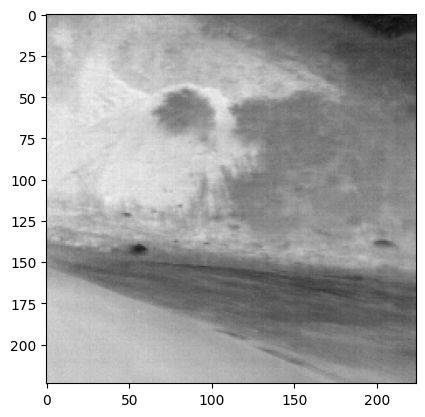

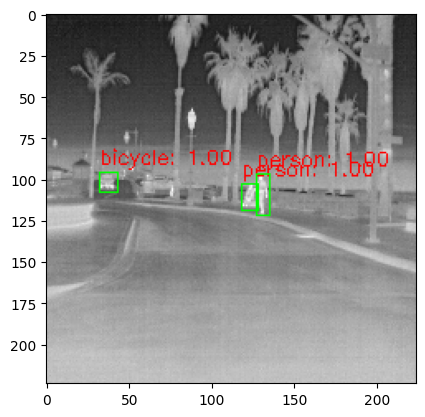

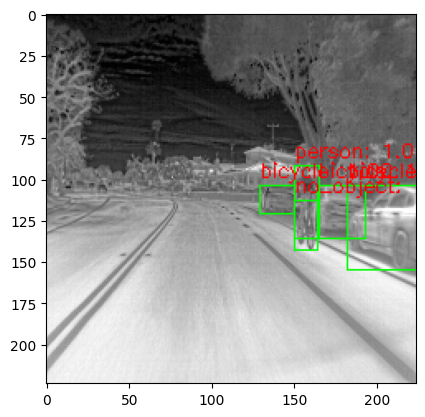

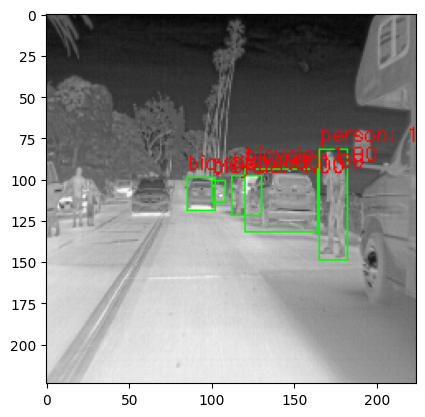

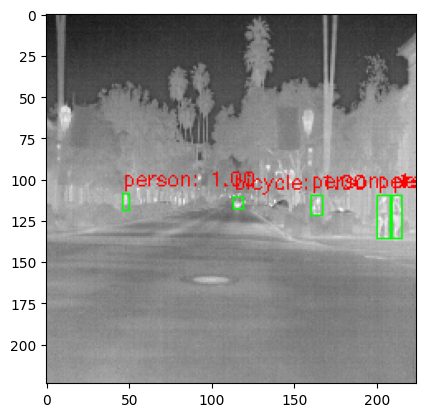

In [9]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Mapping from class index to class name
class_index_to_name = {0: 'person', 1: 'dog', 2: 'car', 3: 'bicycle', 4: 'no_object'}

# Function to visualize images with bounding boxes
def visualize_images_with_boxes(dataset, num_images=5):
    # Select a few images from the dataset
    sample_dataset = dataset.take(num_images)

    for data in sample_dataset:
        image = data[0]['mobilenetv2_1.00_224_input'].numpy()
        boxes = data[1]['reshape_bbox'].numpy()
        classification = data[1]['classification'].numpy()

        # Convert image to uint8 and BGR format
        image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

        # Plot bounding boxes using OpenCV
        for i, box in enumerate(boxes):
            xmin, ymin, xmax, ymax = box
            xmin = xmin * 224
            ymin = ymin * 224
            xmax = xmax * 224
            ymax = ymax * 224

            # Draw bounding box
            cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 1)

            # Draw class name and probability
            class_index = np.argmax(classification[i])
            class_name = class_index_to_name[class_index]
            confidence = classification[i, class_index]

            text = f"{class_name}: {confidence:.2f}"
            cv2.putText(image, text, (int(xmin), int(ymin) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

        # Display the image with bounding boxes
        plt.imshow(image)
        plt.show()

# Call the function to visualize 5 images from the dataset
visualize_images_with_boxes(valid_ds, num_images=5)


# Designing Model Architecture

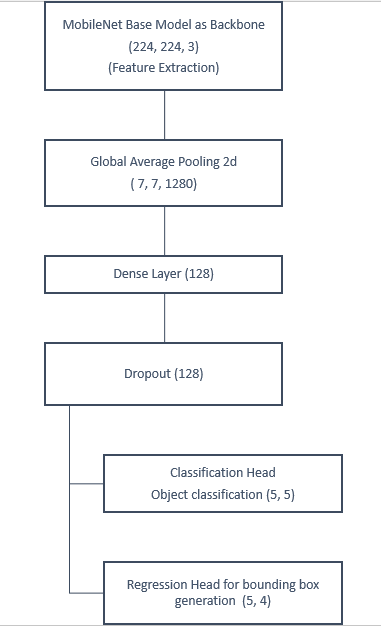

As shown in the figure, we used pre-trained MobileNet architecture as the backbone of our feature extraction layer. Its input size is 224,224,3 which is standard for this network. After this, we used pooling and then used a dense layer which will be trained on our dataset. A dropout layer was used to avoid the chances of overfitting. Lastly, classification head is used to classify objects in boxes, its shape is (5,5) which means it can classify 5 objects per image and a total of 5 classes. Then Regression head comes to predict bounding box values, its output shape is (5,4) which means per image 5 boxes each with 4 values that are xmin, xmax, ymin, and ymax.

In [10]:


# using MobileNet as backbone for feature extractiion
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freezing its layers
base_model.trainable = False


# Now designing own custom architecture

model = models.Sequential()

# Adding base model
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())

# Adding dense layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

# Two separate parallel branches for classification scores and bounding box predictions

# Classification branch
classification_branch = layers.Dense(5 * 5, activation='softmax', name='classification1')(model.layers[-1].output)
classification_reshaped = layers.Reshape((5, 5), name='classification')(classification_branch)


# Regression Branch for bounding box generation
bbox_branch = layers.Dense(5 * 4, activation='sigmoid', name='bounding_box')(model.layers[-1].output)
bbox_reshaped = layers.Reshape((5, 4), name='reshape_bbox')(bbox_branch)

# model with both branches

model = models.Model(inputs=model.input, outputs=[classification_reshaped, bbox_reshaped])


# Print model summary
model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mobilenetv2_1.00_224_input  [(None, 224, 224, 3)]        0         []                            
  (InputLayer)                                                                                    
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['mobilenetv2_1.00_224_input[0
 tional)                                                            ][0]']                        
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['mobilenetv2_1.00_224[0][0]']
 GlobalAveragePooling2D)       

as shown above, summary of model, we have total of 2427757 parameters, out of which 169773 are trainable becuase of new layers which we added and 2257984 are non trainable because of base model which we freezed.

#Creating Batches

Batches has been created to ensure fast learning of model and fast convergence

In [11]:
# Assuming train_ds is your existing dataset
batch_size = 32

# Batch the dataset
train_ds = train_ds.batch(batch_size)
valid_ds = valid_ds.batch(batch_size)

# Print the number of batches in the dataset
print(len(train_ds))
print(len(valid_ds))


69
15


#Compiling and Fitting Model

In Loss, two separate loss functions were used because there were two parallel heads in the model. For classification, we used one hot encoding, hence, categorical cross entropy was used, and for regression head, mean absolute error was used. Model was trained for 200 epochs and graphs suggest that it was more than enough.

In [12]:


model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Adjust the learning rate as needed
    loss={'classification': 'categorical_crossentropy', 'reshape_bbox': 'mae'},
    metrics={'classification': 'accuracy'}
)


history = model.fit(train_ds, epochs=200, validation_data=valid_ds)

Epoch 1/200
69/69 [==============================] - 19s 106ms/step - loss: 1.8547 - classification_loss: 1.5772 - reshape_bbox_loss: 0.2775 - classification_accuracy: 0.3425 - val_loss: 1.4985 - val_classification_loss: 1.2638 - val_reshape_bbox_loss: 0.2347 - val_classification_accuracy: 0.4769
Epoch 2/200
69/69 [==============================] - 5s 78ms/step - loss: 1.5934 - classification_loss: 1.3301 - reshape_bbox_loss: 0.2633 - classification_accuracy: 0.4405 - val_loss: 1.4144 - val_classification_loss: 1.1869 - val_reshape_bbox_loss: 0.2275 - val_classification_accuracy: 0.5204
Epoch 3/200
69/69 [==============================] - 5s 76ms/step - loss: 1.5122 - classification_loss: 1.2560 - reshape_bbox_loss: 0.2562 - classification_accuracy: 0.4743 - val_loss: 1.3467 - val_classification_loss: 1.1284 - val_reshape_bbox_loss: 0.2183 - val_classification_accuracy: 0.5453
Epoch 4/200
69/69 [==============================] - 5s 68ms/step - loss: 1.4583 - classification_loss: 1.2097

#Saving Model

In [13]:
model.save("/content/drive/MyDrive/trained_model.keras")

#Plotting Accuracies for classification

Training Accuracy is around 90% and val accuracy is around 65%. As it is clear that, val accuracy is not improving and is stuck at 65%, and the major reasos is over fitting because we used very low dataset and very complex model so it was expected.
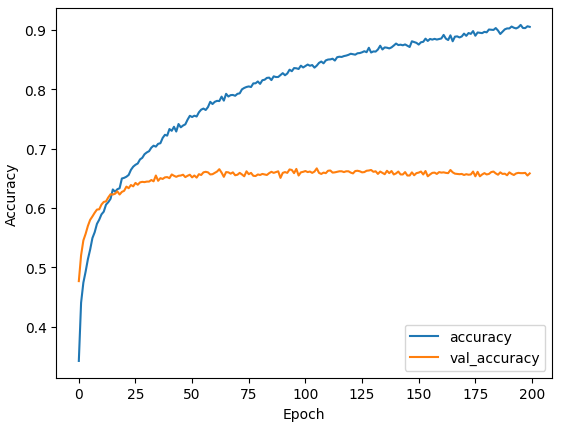

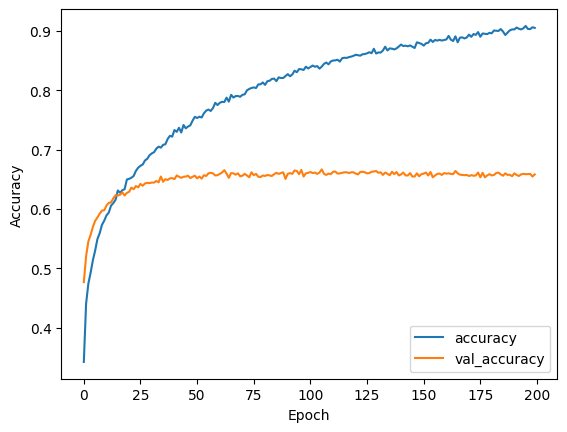

In [14]:
plt.plot(history.history['classification_accuracy'], label='accuracy')
plt.plot(history.history['val_classification_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#Plotting Loss for Bounding Box predictions

Training loss is around 0.12 and validation loss is around 0.15. As loss is for regression head, to predict bounding boxes, it showed similar behaviour as for accuracy for classification head, due to over fitting.
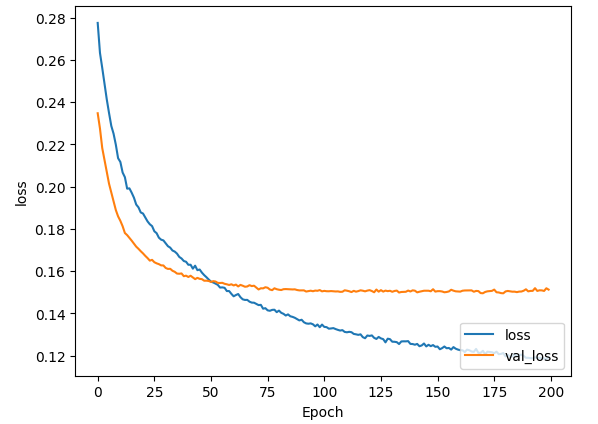

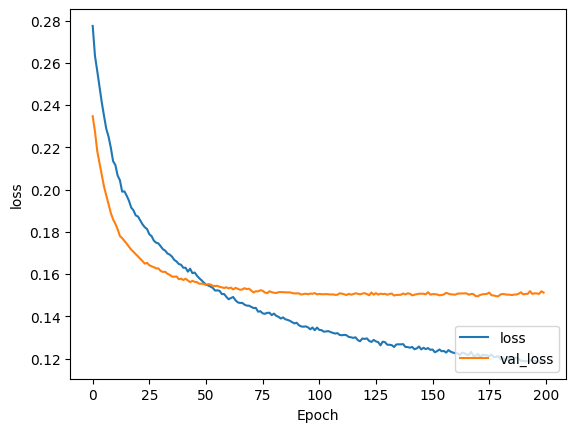

In [15]:


plt.plot(history.history['reshape_bbox_loss'], label='loss')
plt.plot(history.history['val_reshape_bbox_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#Performance Metrics

Confusion matrix was calculated along with average IOU score on validation dataset. Average IOU is 0.19 which is quite low :(. It means overlapping of predicted boxes and ground truth is only 19%.

In [21]:


# Make predictions using the model
predictions = model.predict(valid_ds)

# Classification metrics
classification_predictions = predictions[0].reshape(-1, 5)
classification_targets = np.concatenate([y['classification'] for _, y in valid_ds], axis=0).reshape(-1, 5)
classification_targets = np.argmax(classification_targets, axis=-1)  # Convert one-hot encoding to class indices

print("Performance Metrics:")
print(classification_report(classification_targets, np.argmax(classification_predictions, axis=-1), zero_division=1))

# Bounding box metrics (IoU)
iou_predictions = predictions[1].reshape(-1, 4)
iou_targets = np.concatenate([y['reshape_bbox'] for _, y in valid_ds], axis=0).reshape(-1, 4)

# Compute IoU for each prediction
def calculate_iou(box1, box2):
    x1, y1, width1, height1 = box1
    x2, y2, width2, height2 = box2

    intersection_x = max(x1, x2)
    intersection_y = max(y1, y2)
    intersection_w = max(0, min(x1 + width1, x2 + width2) - intersection_x)
    intersection_h = max(0, min(y1 + height1, y2 + height2) - intersection_y)

    intersection_area = intersection_w * intersection_h
    union_area = (width1 * height1) + (width2 * height2) - intersection_area

    iou = intersection_area / union_area
    return iou

iou_scores = [calculate_iou(pred_box, target_box) for pred_box, target_box in zip(iou_predictions, iou_targets)]
average_iou = np.mean(iou_scores)

print(f"\nAverage IoU: {average_iou}")


15/15 [==============================] - 1s 53ms/step
Performance Metrics:
              precision    recall  f1-score   support

           0       0.58      0.47      0.52       573
           1       0.73      0.72      0.72       541
           2       1.00      0.00      0.00         4
           3       0.66      0.76      0.71      1057
           4       0.60      0.24      0.34        75

    accuracy                           0.66      2250
   macro avg       0.71      0.44      0.46      2250
weighted avg       0.65      0.66      0.65      2250


Average IoU: 0.19342783815088785
